# Entrenamiento de una red neuronal convolucional para el reconocimiento de imágenes de dígitos y letras escritas a mano del dataset EMNIST
### Universidad Tecnológica de la Mixteca
### Carlos Hernández Montellano
### Ingeniería en Computación
### 1002-A.

## CNN utilizando Keras y TensorFlow-GPU con núcleos CUDA

In [42]:
#Se importan las bibliotecas
import numpy as np

import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, BatchNormalization

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import pandas as pd

import time


import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

In [43]:
# Tensorflow revisa si existen GPU's para realizar el procesamiento en CUDA
# En este caso una GeForce 930MX compatible con 403 CUDA Cores
# Si no se encuentran GPU's se usa el CPU
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11204165087460837252
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1462163865
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7814573721406717939
physical_device_desc: "device: 0, name: GeForce 930MX, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


In [44]:
# Se lee el dataset. Por default ya se tienen las particiones estratificadas
train_pd = pd.read_csv('emnist/emnist-balanced-train.csv')
test_pd = pd.read_csv('emnist/emnist-balanced-test.csv')
train_pd.head()

,45,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.524,0.525,0.526,0.527,0.528,0.529,0.530,0.531,0.532,0.533
0,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,43,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,42,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
# Partición de los datos de las etiquetas y las imágenes
train_data_pd = train_pd.iloc[:, 1:]
train_labels_pd = train_pd.iloc[:, 0]
test_data_pd = test_pd.iloc[:, 1:]
test_labels_pd = test_pd.iloc[:, 0]

In [46]:
# One hot encoder de Pandas
train_labels_onehot_pd = pd.get_dummies(train_labels_pd)
test_labels_onehot_pd = pd.get_dummies(test_labels_pd)
train_labels_onehot_pd.head()

,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,45,46
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [47]:
# Pasamos de pandas a numpy
train_data = train_data_pd.values
y_train = train_labels_onehot_pd.values
y_train_nohot = train_labels_pd.values
test_data = test_data_pd.values
y_test = test_labels_onehot_pd.values
y_test_nohot = train_labels_pd.values

In [48]:
# Borramos los datos de pandas para liberar memoria.
# Dejo solo train_labels_pd y test_labels_pd
del train_labels_onehot_pd,  test_labels_onehot_pd, train_data_pd, test_data_pd, train_pd, test_pd

In [49]:
# Normalizamos datos
mms = MinMaxScaler()
x_train = mms.fit_transform(train_data)
x_test = mms.fit_transform(test_data)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [52]:
# Aplicamos reshape a los conuntos para que queden como matrices
TRAIN_PATTERN_NUMBER = x_train.shape[0]
TEST_PATTERN_NUMBER = x_test.shape[0]
x_train = x_train.reshape(TRAIN_PATTERN_NUMBER, 28, 28, 1)
x_test = x_test.reshape(TEST_PATTERN_NUMBER, 28, 28, 1)

In [53]:
print(x_train.shape)
print(x_test.shape)

(112799, 28, 28, 1)
(18799, 28, 28, 1)


In [85]:
# Forma en que está organizados los targets del dataset.
NUM_TARGETS = y_test.shape[1]
LABELS = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt'

### Definición de funciones

In [55]:
# Función que a partir de los datos del one hot encoder, se retorna
# el indice del valor real de la etiqueta
def one_hot_decoder (binary_encoded_label):
    return np.argmax(binary_encoded_label)

In [56]:
# Función para hacer plot a cualquier imágen con su correspondiente clase
def show_img(img,label):
    img_t = img.reshape(28, 28).T
    plt.title('Etiqueta: ' + str(LABELS[one_hot_decoder(label)]))
    plt.imshow(img_t)

In [57]:
# Función para evaluar el modelo con el conjunto de test
def evaluate_model (model, test_x, test_y):
    result = model.evaluate(test_x, test_y)
    print("El accuracy del modelo es: ", result[1])
    return result

In [58]:
# Función que despliega una gráfica del accuracy y el error a través de los epoch
def plot_graph(history):
    # accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Exactitud del modelo de la CNN')
    plt.ylabel('exactitud')
    plt.xlabel('época')
    plt.legend(['Entrenamiento', 'Validación'], loc='lower right')
    plt.show()

    # error
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Error del modelo de la CNN')
    plt.ylabel('error')
    plt.xlabel('época')
    plt.legend(['Entrenamiento', 'Validación'], loc='upper right')
    plt.show()

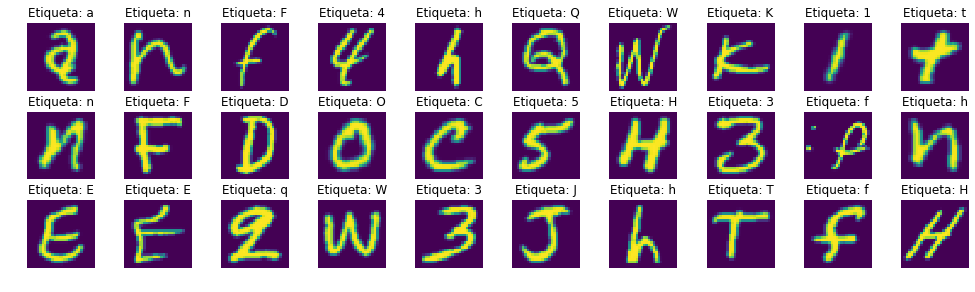

In [69]:
# Algunas muestras del dato de entrenamiento
fig = plt.figure(figsize=(17, 4.5))
for idx in range(30):
    fig.add_subplot(3, 10, idx + 1)
    plt.axis('off')
    show_img(x_train[idx], y_train[idx])
plt.subplots_adjust(wspace=0.3, hspace=0.3)

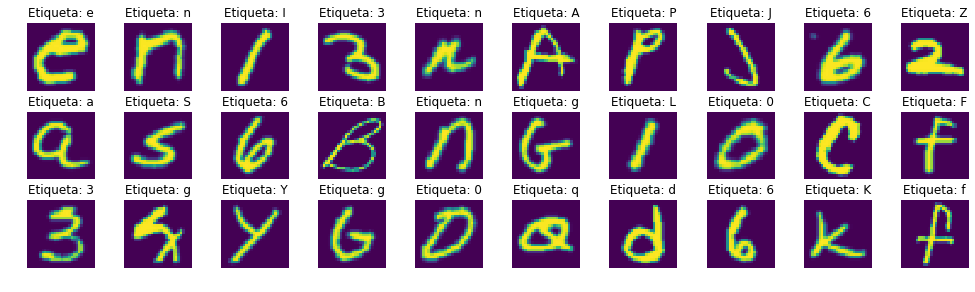

In [70]:
# Algunas muestras del dato de test
fig = plt.figure(figsize=(17, 4.5))
i = 1
for idx in range(0, x_test.shape[0], 500):
    fig.add_subplot(3, 10, i)
    plt.axis('off')
    show_img(x_test[idx], y_test[idx])
    i += 1
    if (i == 31):
        break
plt.subplots_adjust(wspace=0.3, hspace=0.3)

### Arquitectura de la CNN

In [71]:
# Se define la arquitectura de la CNN

# La arquitectura se puede definir por batches de una forma
# muy sencilla gracias a Keras

# El BatchNormalizacion se usa para que las capas de activación de
# las capas anteriores de cada batch se normalice, es decir
# se aplica una transformación que mantiene la media de la
# activación cerca de 0 y la desviación estandar cercano a 1.

# En el caso de esta arquitectura se usan varias capas de convolución
def model_CNN (input_size, output_size):
    model = Sequential()
    
    # Capa 1 de convolución y pooling. 32 filtros de 3x3 con 28x28 entradas y pooling a 24x24
    model.add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (input_size[0], input_size[1], input_size[2])))
    model.add(BatchNormalization())
    # Capa 2 de convolución y pooling. 32 filtros de 3x3 con 24x24 entradas y pooling a 12x12
    model.add(Conv2D(32, kernel_size = 3, activation='relu'))
    model.add(BatchNormalization())
    # Capa 3 de convolución y pooling. 32 filtros de 5x5 con 12x12 entradas y pooling a 10x10
    model.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    
    # Capa 4 de convolución y pooling. 64 filtros de 3x3 con 10x10 entradas y pooling a 8x8
    model.add(Conv2D(64, kernel_size = 3, activation='relu'))
    model.add(BatchNormalization())
    # Capa 5 de convolución y pooling. 64 filtros de 3x3 con 8x8 entradas y pooling a 4x4
    model.add(Conv2D(64, kernel_size = 3, activation='relu'))
    model.add(BatchNormalization())
    # Capa 6 de convolución y pooling. 64 filtros de 5x5 con 4x4 entradas y MaxPooling a 1x1
    model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    # adapten al tamaño de las entradas.
    # Capa 7 de convolución y pooling. 128 filtros de 4x4 con 1x1 entradas
    model.add(Conv2D(128, kernel_size = 4, activation='relu'))
    model.add(BatchNormalization())
    # El flatten conecta las salidas del preprocesamiento al clasificador, es decir, conecta
    # las salidas del pooling de la última capa de convolución a las entradas de la capa
    # completamente conectada.
    model.add(Flatten())
    model.add(Dropout(0.4))
    
    # Full Connected Layer
    model.add(Dense(output_size, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])
    
    return model

In [72]:
# Se instancia el modelo y se muestra la arquitectura de la CNN
model_instance = model_CNN([28, 28, 1], y_train.shape[1])
model_instance.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_v1_7 (Ba (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_v1_8 (Ba (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 12, 12, 32)        25632     
_________________________________________________________________
batch_normalization_v1_9 (Ba (None, 12, 12, 32)        128       
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 32)        0         
__________

### Entrenamiento de la CNN

In [73]:
BATCH_SIZE = 64

history = model_instance.fit(x_train, y_train,
          batch_size = BATCH_SIZE,
          epochs = 15,
          validation_split = 0.1)

Train on 101519 samples, validate on 11280 samples
Epoch 1/15
101519/101519 [==============================] - 124s 1ms/sample - loss: 0.8957 - acc: 0.7307 - val_loss: 0.4258 - val_acc: 0.8474
Epoch 2/15
101519/101519 [==============================] - 119s 1ms/sample - loss: 0.4775 - acc: 0.8359 - val_loss: 0.3641 - val_acc: 0.8669
Epoch 3/15
101519/101519 [==============================] - 120s 1ms/sample - loss: 0.4254 - acc: 0.8520 - val_loss: 0.3437 - val_acc: 0.8711
Epoch 4/15
101519/101519 [==============================] - 119s 1ms/sample - loss: 0.3921 - acc: 0.8620 - val_loss: 0.3276 - val_acc: 0.8752
Epoch 5/15
101519/101519 [==============================] - 119s 1ms/sample - loss: 0.3714 - acc: 0.8686 - val_loss: 0.3185 - val_acc: 0.8812
Epoch 6/15
101519/101519 [==============================] - 119s 1ms/sample - loss: 0.3542 - acc: 0.8725 - val_loss: 0.3132 - val_acc: 0.8832
Epoch 7/15
101519/101519 [==============================] - 119s 1ms/sample - loss: 0.3424 - acc:

### Evaluación de la CNN entrenada

In [89]:
evaluate_model (model_instance, x_test, y_test)

18799/18799 [==============================] - 20s 1ms/sample - loss: 0.3024 - acc: 0.8902
El accuracy del modelo es:  0.8901537


[0.30237727504416, 0.8901537]

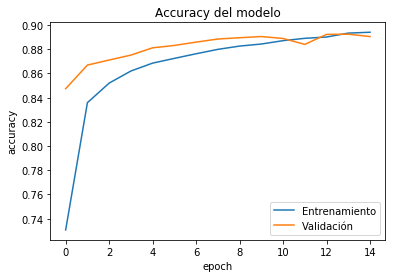

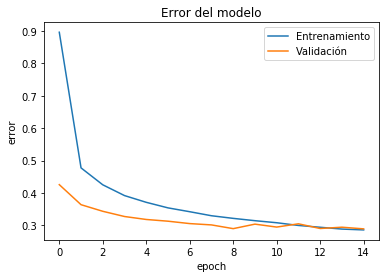

In [75]:
plot_graph(history)

## Guardar el modelo

In [82]:
# El modelo se guarda en JSON y los pesos que resultaron del entrenamiento
# se guardan en HDF5
# Se seraliza el modelo a JSON
model_json = model_instance.to_json()
with open("CNN_model_EMNIST_GPU.json", "w") as json_file:
    json_file.write(model_json)
# Se serializan los pesos a HDF5
model_instance.save_weights("CNN_model_EMNIST_GPU.h5")
print("Se guardó el modelo con éxito")

Se guardó el modelo con éxito
